# Next Word Prediction By Sanjana Birari

<a name="ilp"></a>
# Import necessary libraries and packages 

In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

<a name="di"></a>
# Dataset information

**Import Medium-articles-dataset:**

This dataset contains information about randomly chosen medium articles published in 2019 from these 7 publications:

- Towards Data Science
- UX Collective
- The Startup
- The Writing Cooperative
- Data Driven Investor
- Better Humans
- Better Marketing


In [2]:
medium_data = pd.read_csv('../input/medium-articles-dataset/medium_data.csv')
medium_data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


Here, we have a **10 different fields and 6508 records** but we will only use **title field** for predicting next word. 

In [3]:
print("Number of records: ", medium_data.shape[0])
print("Number of fields: ", medium_data.shape[1])

Number of records:  6508
Number of fields:  10


<a name="preprocess"></a>
# Display titles of various articles  and preprocess them

In [4]:
medium_data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

<a name="remv"></a>
#### Removing unwanted characters and words in titles

Looking at titles, we can see there are some of unwanted characters and words in it which can not be useful for us to predict infact it might decrease our model accuracy so we have to remove it.

In [5]:
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace(u'\xa0',u' '))
medium_data['title'] = medium_data['title'].apply(lambda x: x.replace('\u200a',' '))

<a name="token"></a>
#### Tokenzation

Tokenzaion is the process in which we provide an unique id to all the words and make a word index or we can say vocabulary.

In [6]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(medium_data['title'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("And: ", tokenizer.word_index['and'])
print("Consumption: ", tokenizer.word_index['consumption'])

Total number of words:  8238
Word: ID
------------
<oov>:  1
Strong:  4
And:  8
Consumption:  8237


In [7]:
input_sequences = []
for line in medium_data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


<a name="pad"></a>
#### Make all titles with same length by using padding

The length of every title has to be the same. To make it, we need to find a title that has a maximum length, and based on that length, we have to pad rest of titles.

In [8]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

<a name="xy"></a>
# Prepare features and labels

Here, we consider **last element of all sequences as a label**.Then,
We need to perform **onehot encoding on labels corresponding to total_words.**

In [9]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [10]:
print(xs[5])
print(labels[5])
print(ys[5][14])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    5  676   68    2  452 1518]
14
1.0


<a name="train"></a>
# Bi- LSTM Neural Network Model training

In [11]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)


Epoch 1/50
1515/1515 [==============================] - 34s 17ms/step - loss: 7.0530 - accuracy: 0.0954
Epoch 2/50
1515/1515 [==============================] - 26s 17ms/step - loss: 5.7356 - accuracy: 0.1782
Epoch 3/50
1515/1515 [==============================] - 26s 17ms/step - loss: 5.6599 - accuracy: 0.1953
Epoch 4/50
1515/1515 [==============================] - 25s 17ms/step - loss: 4.0451 - accuracy: 0.2716
Epoch 5/50
1515/1515 [==============================] - 26s 17ms/step - loss: 3.4630 - accuracy: 0.3298
Epoch 6/50
1515/1515 [==============================] - 26s 17ms/step - loss: 3.1533 - accuracy: 0.3594
Epoch 7/50
1515/1515 [==============================] - 26s 17ms/step - loss: 2.8815 - accuracy: 0.3967
Epoch 8/50
1515/1515 [==============================] - 25s 17ms/step - loss: 2.7300 - accuracy: 0.4118
Epoch 9/50
1515/1515 [==============================] - 26s 17ms/step - loss: 2.5706 - accuracy: 0.4391
Epoch 10/50
1515/1515 [==============================] - 26s 17m

<a name="acc"></a>
# Plotting model accuracy and loss

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

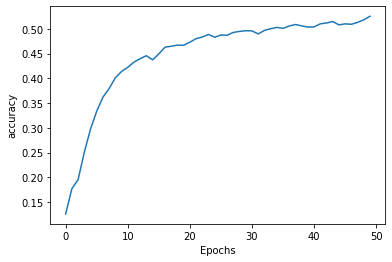

In [13]:
plot_graphs(history, 'accuracy')

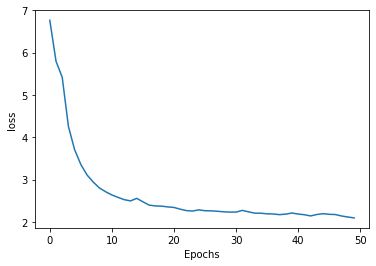

In [14]:
plot_graphs(history, 'loss')

<a name="new"></a>
# Predicting next word of title

In [15]:
seed_text = "implementation of"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


implementation of rnn lstm
